# Projeto 05 - NLP e ML em Medicina para Classificação de Mutações Genéticas em Tumores Cancerígenos

Muito tem sido dito durante os últimos anos sobre como a medicina de precisão e, mais concretamente, como o teste genético, vai provocar disrupçãono tratamento de doenças como o Câncer.

Mas isso ainda está acontecendo apenas parcialmente devido a enorme quantidade de trabalho manual ainda necessário. Neste projeto, tentaremos levar a medicina personalizada ao seu potencial máximo.

Uma vez sequenciado, um tumor cancerígeno pode ter milhares de mutações genéticas. O desafio é distinguir as mutações que contribuem para o crescimento do tumor das mutações.

Atualmente, esta interpretação de mutações genéticas está sendo feita manualmente. Esta é uma tarefa demorada, onde um patologista clínico tem que revisar manualmente e classificar cada mutação genética com base em evidências da literatura clínica baseada em texto.

Para este projeto, o Memorial Sloan Kettering Cancer Center está disponibilizando uma base de conhecimento anotada por especialistas, onde pesquisadores e oncologistas de nível mundial anotaram manualmente milhares de mutações.

Neste projeto, vamos desenvolver um algoritmo de Aprendizado de Máquina que, usando essa base de conhecimento como uma linha de base, classifica automaticamente as variações genéticas.

O dataset completo pode ser encontrado em:

[https://www.kaggle.com/c/msk-redefining-cancer-treatment/data](https://www.kaggle.com/c/msk-redefining-cancer-treatment/data) 

Vamos utilizar Python para a criação de um modelo de Deep Learning com Keras.

## Descrição dos Dados

Há 9 tipos diferentes de classes que uma mutação genética pode ser classificada.

Os dados de treino e teste são constituidos por 2 arquivos diferentes. O primeiro (treino/teste_variantes) fornece a informação sobre as mutações genéticas, o segundo (treino/teste text) fornece as evidências clínicas que os especialistas usam para classificar as mutações genéticas. Os dois arquivos são linkados pela coluna ID.

Exemplificando, a mutação genética localizada na linha com ID=15 no arquivo de variantes, foi classificada usando as evidencias clínicas da linha com ID=15 no arquivo de evidências (text).

Por fim, para as coisas ficarem mais dramáticas, alguns dados do arquivo de test foram gerados por computador pra evitar que fossem feitos manualmente. Nós devemos ignorar as amostras geradas por computador.

### Detalhes dos Arquivos

- **training_variants** → uma vírgula separa as descrições das mutações genéticas usadas para treinamento. Os campos são **ID** (utilizado para fazer o link com o dataset de evidencias), **Gene** ( o gene onde a mutação genética está localizada), **Variation** (a mudança de aminoácido desta mutação), **Class** (a classe de 1-9 que a mudança genética foi classificada).
  
- **training_text** → barras duplas (||) delimitam o conteúdo das evidencias clinicas usadas para classificar as mutações genéticas. Os campos são **ID** (utilizado para o link com o dataset de variantes), **Text** (as evidências clínicas utilizadas para classificar as mutações genéticas).
  
- **test_variants** → uma vírgula separa as descrições das mutações genéticas usadas para treinamento. Os campos são **ID** (utilizado para fazer o link com o dataset de evidencias), **Gene** ( o gene onde a mutação genética está localizada), **Variation** (a mudança de aminoácido desta mutação).
  
- **test_text** → barras duplas (||) delimitam o conteúdo das evidencias clinicas usadas para classificar as mutações genéticas. Os campos são **ID** (utilizado para o link com o dataset de variantes), **Text** (as evidências clínicas utilizadas para classificar as mutações genéticas).

## Carregando os Pacotes

In [1]:
from platform import python_version
print('A Versão da Linguagem Python utilizada neste projeto é ', python_version())

A Versão da Linguagem Python utilizada neste projeto é  3.9.16


In [2]:
# Manipuluação e Vizualização de Dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import string
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pré - Processamento de Texto
import re
import nltk
import sklearn
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

# Modelos de Machine Learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Métricas dos Modelos
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Retirando Avisos
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Registrando as Versões dos Pacotes
%reload_ext watermark
%watermark -a "Thiago Bulgarelli" --iversions

Author: Thiago Bulgarelli

matplotlib: 3.6.2
pandas    : 1.5.2
wordcloud : 1.8.2.2
nltk      : 3.7
re        : 2.2.1
numpy     : 1.23.5
plotly    : 5.9.0
sklearn   : 1.0.2



## Carregamento dos Dados

In [4]:
# Carregando os Datasets
train_Ev = pd.read_csv('dados/training_text', sep="\|\|", engine='python')
train_Var = pd.read_csv('dados/training_variants', sep=',')
test_Ev = pd.read_csv('dados/test_text', sep='\|\|',  engine='python')
test_Var = pd.read_csv('dados/test_variants', sep=',')


In [5]:
# Visualizando as Evidências de Treino
print(train_Ev.info())
train_Ev.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   Text    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB
None


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
# Visualizando as Variantes de Treino
print(train_Var.info())
train_Var.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB
None


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [7]:
# Visualizando as Evidências de Teste
print(test_Ev.info())
test_Ev.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      5668 non-null   int64 
 1   Text    5667 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.7+ KB
None


,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [8]:
# Visualizando as Variantes de Teste
print(test_Var.info())
test_Var.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5668 non-null   int64 
 1   Gene       5668 non-null   object
 2   Variation  5668 non-null   object
dtypes: int64(1), object(2)
memory usage: 133.0+ KB
None


,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [9]:
# Unindo o Dataset de Treino para Limpeza e Transformação
df = train_Ev.merge(train_Var, how='right', on='ID')

# Visualizando Dataset de Treino Completo
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Text       3316 non-null   object
 2   Gene       3321 non-null   object
 3   Variation  3321 non-null   object
 4   Class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB
None


,ID,Text,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [10]:
# Unindo o Dataset de Teste para deixar aos moldes do Dataset de Treino
dft = test_Ev.merge(test_Var, how='right', on='ID')

# Visualizando Dataset de Teste Completo
print(dft.info())
dft.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5668 entries, 0 to 5667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5668 non-null   int64 
 1   Text       5667 non-null   object
 2   Gene       5668 non-null   object
 3   Variation  5668 non-null   object
dtypes: int64(1), object(3)
memory usage: 221.4+ KB
None


,ID,Text,Gene,Variation
0,0,2. This mutation resulted in a myeloproliferat...,ACSL4,R570S
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...,NAGLU,P521L
2,2,Vascular endothelial growth factor receptor (V...,PAH,L333F
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...,ING1,A148D
4,4,Abstract Retinoblastoma is a pediatric retina...,TMEM216,G77A


## Limpeza e Transformação dos Dados
Vamos aplicar técnicas de Processamento de Texto para deixar apenas as palavras mais importantes de cada observação.

Também vamos verificar se temos dados faltantes e observar a necessidade de substituí-los ou elimininá-los de nossos estudos.

In [11]:
# Analisando as Informações Básicas do Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Text       3316 non-null   object
 2   Gene       3321 non-null   object
 3   Variation  3321 non-null   object
 4   Class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [12]:
# Verificando dados Ausentes
df.isna().sum()

ID           0
Text         5
Gene         0
Variation    0
Class        0
dtype: int64

In [13]:
# Excluindo as Observações sem Informação
df.dropna(inplace=True)
print(df.isna().sum())

ID           0
Text         0
Gene         0
Variation    0
Class        0
dtype: int64


In [14]:
# Carregando as StopWords em Ingles
nltk.download('stopwords')
SW = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bugath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Função de Processar o texto
def text_process(text):
    text = str(text)

    # Transforma o Texto em Letras Minúsculas
    text = text.lower()

    # Remove as Pontuações
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ',
                text)
    
    # Remove as Tags HTML
    text = re.sub('<.*?>+', ' ', text)

    # Remove Caracteres Especiais
    text = re.sub('[^a-zA-Z0-9\n]', ' ', text)

    # Remove Multiplos Espaços
    text = re.sub(r'\s+', ' ', text)

    # Tokenização do Texto
    text_tokens = word_tokenize(text)

    # Separa as Sentenças em Palavras
    text = text.split()

    #Remove as StopWords
    tw = [word for word in text_tokens if word is not SW]
    text = (' ').join(tw)

    return text

In [16]:
# Aplicando a Função text_process no Dataset de Treino
df['Text'] = df['Text'].apply(text_process)
print(df.info())
print(df.isnull().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3316 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3316 non-null   int64 
 1   Text       3316 non-null   object
 2   Gene       3316 non-null   object
 3   Variation  3316 non-null   object
 4   Class      3316 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.4+ KB
None
ID           0
Text         0
Gene         0
Variation    0
Class        0
dtype: int64


,ID,Text,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate a varie...,FAM58A,Truncating Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2
2,2,abstract background non small cell lung cancer...,CBL,Q249E,2
3,3,recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,oncogenic mutations in the monomeric casitas b...,CBL,L399V,4


Dados Limpos e Organizados! Estamos prontos para entender melhor sobre os dados e prosseguir com nossos estudos.

## Análise Exploratória dos Dados
Nosso objetivo aqui é explorar nossos dados e identificar informações ocultas nas relações entre variáveis. 

In [17]:
# Criando uma Cópia do Dataset Original
dfEDA = df.copy()

### Variável Gene

In [18]:
# Analisando os dados Unicos
dfEDA['Gene'].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RICTOR      1
PIK3R3      1
PPM1D       1
WHSC1       1
FAM58A      1
Name: Gene, Length: 262, dtype: int64

In [19]:
# Distribuição dos tipos de Genes
fig = px.bar(dfEDA['Gene'].value_counts(), title='Frequência dos Tipos de Genes')
fig.update_xaxes(title_text = 'Genes')
fig.update_yaxes(title_text = 'Contagem de Observações')

In [20]:
# Frequência Acumulada por Tipo de Gene
y = dfEDA['Gene'].value_counts(normalize=True)
fig = px.ecdf(x = dfEDA['Gene'].value_counts(), y = y, ecdfnorm=None, ecdfmode='complementary', title='Frequência Acumulada por Gene')
fig.update_xaxes(title_text = 'Contagem por Genes')
fig.update_yaxes(title_text = 'Frequência Acumulada')

Ponto interessante:
- Podemos afirmar que os genes com mais de 16 ocorrências em nosso dataset comteplam 75% dos casos classificados.

In [21]:
# Distribuição dos tipos de Genes 10+
dfEDA1 = dfEDA['Gene'].value_counts().copy()
dfEDA1 = dfEDA1.head(10)
fig = px.bar(dfEDA1, title='Frequência dos Tipos de Genes')
fig.update_xaxes(title_text = 'Genes')
fig.update_yaxes(title_text = 'Frequência Absoluta')

Ponte Interessante:
- Os Genes mais comuns abordam 34% das nossas Observações. São eles, BRCA1, TP53, EGFR, PTEN, BRCA2, KIT, BRAF, ALK, ERBB2 e PDGFRA

### Variável Variation

In [22]:
# Analisando os dados Unicos
dfEDA2 = dfEDA.copy()
dfEDA2['Variation'].value_counts()

Truncating Mutations    92
Deletion                74
Amplification           70
Fusions                 34
Overexpression           6
                        ..
H1094R                   1
M1250T                   1
PTPRZ1-MET Fusion        1
H1106D                   1
K83E                     1
Name: Variation, Length: 2993, dtype: int64

In [23]:
# Frequência Acumulada por Tipo de Variação
y = dfEDA2['Variation'].value_counts(normalize=True)
x = dfEDA2['Variation'].value_counts()
fig = px.ecdf(x= x, y=y, ecdfnorm=None, ecdfmode='complementary', title='Frequência Acumulada por Variação')
fig.update_xaxes(title_text = 'Contagem por Variação')
fig.update_yaxes(title_text = 'Frequência Acumulada')

In [24]:
# Frequência Absoluta dos tipos de Variação 10+
x = dfEDA2['Variation'].value_counts().head(10)
fig = px.bar(x, title='Frequência dos Tipos de Variação')
fig.update_xaxes(title_text = 'Variation')
fig.update_yaxes(title_text = 'Frequência Absoluta')

Ponte Interessante:
- As Variações mais comuns abordam 8% das nossas Observações. São eles, Truncating Mutations, Deletion, Amplification e Fusions.
- Fica claro que temos praticamente 1 variação diferente para cada observação, levando em consideração que temos 2993 varições diferentes para 3316 observações.

### Variável Class - Resposta
Para nossa Variável Resposta, vamos entender como está distribuída e identificar uma possível necessidade de equilibrar as classes.

In [25]:
# Analisando as Quantidades de Cada Classe
dfEDA3 = dfEDA.copy()
dfEDA3['Class'].value_counts()

7    952
4    686
1    566
2    452
6    273
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [26]:
# Distribuição dos tipos de Classe
fig = px.bar(dfEDA3['Class'].value_counts(), title='Frequência das Classes')
fig.update_xaxes(title_text = 'Classe')
fig.update_yaxes(title_text = 'Frequência Absoluta')

Ponto Interessante:
- Podemos verificar que a variável resposta tem um desequilibrio claro entre as classes e portanto é necessário avaliar uma possível tratativa para tema durante o Pré-processamento.

Vamos ainda observar os tipos de genes por Classe para verficar se temos comportamentos diferentes.

In [27]:
# Preparando um Dataframe para os 5 Mais Frequentes Genes
dfEDA4 = dfEDA.copy()
filtro = ['BRCA1', 'TP53', 'EGFR', 'PTEN', 'BRCA2']
dfEDA4 = dfEDA4[dfEDA4['Gene'].isin(filtro)]
dfEDA4

,ID,Text,Gene,Variation,Class
138,138,non small cell lung cancer is the leading caus...,EGFR,L747_T751delinsP,7
139,139,in contrast to other primary epidermal growth ...,EGFR,S752_I759del,2
140,140,the accurate determination of perfluoroalkyl s...,EGFR,I491M,5
141,141,in contrast to other primary epidermal growth ...,EGFR,D770_P772dup,7
142,142,purpose clinical features of epidermal growth ...,EGFR,G719A,7
...,...,...,...,...,...
2894,2894,abstract classification of rare missense varia...,BRCA2,S2670L,5
2895,2895,twenty percent of individuals with a strong fa...,BRCA2,M2676T,6
2896,2896,mutation screening of the breast and ovarian c...,BRCA2,Q1396R,6
2897,2897,purpose rare missense substitutions and in fra...,BRCA2,K607T,6


In [28]:
# Analisando os 5 Genes de Maior Frequência, em relação as Classes
fig = px.bar(x=dfEDA4['Gene'], facet_col=dfEDA4['Class'])
fig.show()

Temos um conjunto de dados bastante diluído entre as Classes, o que não nos dá muitas informações sobre o padrão dos dados.

### Variável Text

Vamos observar a Variável Text apenas dos Genes mais frequentes, pois o volume de dados é muito grande para nossa capacidade computacional. O importante é termos uma visão dos termos mais utilizados dentro do dataset e verificarmos se temos insights interessantes.

In [29]:
# Criando uma cópia do Dataset com os Genes Mais Frequentes com a Variável Text
dfEDA5 = dfEDA4['Text'].copy()

# Visualizando as 5 primeiras observações
dfEDA5.head()

138    non small cell lung cancer is the leading caus...
139    in contrast to other primary epidermal growth ...
140    the accurate determination of perfluoroalkyl s...
141    in contrast to other primary epidermal growth ...
142    purpose clinical features of epidermal growth ...
Name: Text, dtype: object

In [30]:
# Criando nosso Volume de Palavras
DataCloud = " ".join(review for review in dfEDA5)

# Verificando o Comprimento da Lista de Palavras
len(DataCloud)

48095828

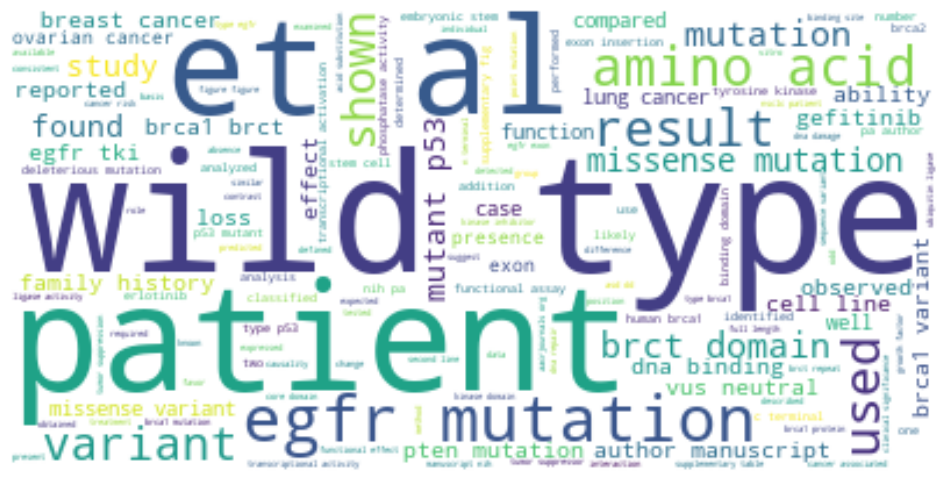

In [31]:
# Criando uma WordCloud
stopwordswd=set(STOPWORDS)
WD = WordCloud(stopwords=stopwordswd, background_color='white').generate(DataCloud)
plt.figure(figsize=(12,12))
plt.imshow(WD, interpolation='bilinear')
plt.axis('off')
plt.show()

Podemos identificar alguma palavras muito frequentes como "mutation", genes que identificamos pela frequência como "p53", "brca1", "brct" e "egfr", e algumas palavras bastante impactantes como "patient", "Wild Type" e "family history".

Por ser um texto técnico bastante complexo, percebemos que nossa tokenização falhou em alguns momentos, assim como as stopwords. Porém acredito que seja o suficiente para iniciarmos nosso pré-processamento. Vamos seguir em frente!

## Pré-Processamento

Vamos preparar os dados para nosso modelagem preditiva.

Como vimos no EDA, temos uma variável “Class” desequilibrada em relação as suas 9 classes possíveis. Porém estamos trabalhando com dados não relacionais, variáveis de texto que não podemos gerar mais dados sintéticos. Também ficaria inviável aplicar unersampling, pois a discrepância entre as classes é muito grande. Sendo assim, vamos prosseguir com a variável resposta desequilibrada e obter o melhor desempenho possível em nossos Modelos de Machine Learning.

Como o intuito do trabalho é utilizar os textos de literatura para classificar os genes e suas mutações, faremos a vetorização TF-IDF somente para a Variável Text. Logo após faremos a divisão em Treino e Teste. Após esses procedimentos, estaremos prontos para começar a desenvolver nossos Modelos de ML.

In [32]:
# Aplicando Vetorização nos dados com TF-IDF na Variável Text
vetorizador = TfidfVectorizer().fit(df['Text'])
X = vetorizador.transform(df['Text'])
y = df.Class

In [33]:
# Verificando o Shape da Variável de Entrada
X.shape

(3316, 153173)

In [34]:
# Separando os dados em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Tudo Pronto! Podemos começar a Desenvolver Modelos de Aprendizagem de Máquina!

## Machine Learning Aplicada

Vamos trabalhar com os algoritmos K-Nearest Neighbors, Random Forest Classifier, Multinomial Naive Bayes e Stochasitic Gradient Descent.

Para cada modelo, calcularemos as Métricas:
- Log Loss
- ROC AUC

Faremos a compilação dos Resultaos em um Dataframe para então decidirmos qual faremos o Deploy.

### Modelo 00 - K-Nearest Neighbors

In [35]:
# Testando o Melhor Valor de K
klist = [3, 10, 20, 30, 50, 80, 100, 200, 300, 500, 800, 1000]

# Lista de Log Loss de K
LogLoss = []
rAUC = []

# Loop de Teste
for k in klist:
		
	# Treinando o modelo KNN com cada valor de k
	modelo = KNeighborsClassifier(n_neighbors = k)
	modelo.fit(X_train, y_train)

	# Previsões com o modelo
	pred = modelo.predict_proba(X_test)

	# Avaliando o modelo com a lista de Métricas
	score1 = log_loss(y_test, pred, eps=1e-15)
	score2 = roc_auc_score(y_test, pred, multi_class='ovr')
	print(f'As métricas para k={k} são:\nLog Loss {score1} \nrAUC = {score2}\n------------------------\n')
	LogLoss.append(score1)
	rAUC.append(score2)

As métricas para k=3 são:
Log Loss 7.2469291862376375 
rAUC = 0.8317891744856349
------------------------

As métricas para k=10 são:
Log Loss 3.461789199254402 
rAUC = 0.8543974087100542
------------------------

As métricas para k=20 são:
Log Loss 2.273187752857395 
rAUC = 0.854930572989245
------------------------

As métricas para k=30 são:
Log Loss 2.0759173896354843 
rAUC = 0.8412752632396319
------------------------

As métricas para k=50 são:
Log Loss 1.761707324536837 
rAUC = 0.8305992023758364
------------------------

As métricas para k=80 são:
Log Loss 1.7398057398708717 
rAUC = 0.8181349965632221
------------------------

As métricas para k=100 são:
Log Loss 1.7840949125406764 
rAUC = 0.8121780263484553
------------------------

As métricas para k=200 são:
Log Loss 1.810393434413759 
rAUC = 0.7986984307944747
------------------------

As métricas para k=300 são:
Log Loss 1.8018078038309575 
rAUC = 0.8002878299844858
------------------------

As métricas para k=500 são:
Log

In [36]:
# Visão Gráfica das Métricas
dic = {'K': klist, 'Log Loss': LogLoss, 'rAUC': rAUC}
data = pd.DataFrame(dic)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Log Loss', 'rAUC'])
fig.add_trace(go.Scatter(x = data['K'], y = data['Log Loss'], mode='lines', showlegend=False), row=1, col=1)
fig.update_yaxes(showticklabels = True)
fig.add_trace(go.Scatter(x = data['K'], y = data['rAUC'], mode='lines', showlegend=False), row=1, col=2)
fig.update_layout(title_text = 'Métricas do Modelo KNN')
fig.show()

A perda logarítmica (Log Loss) representa o quanto a probabilidade prevista se aproxima do valor real, ou seja, quanto mais a probabilidade prevista diverge do valor real, mais alto será a perda logaritmica. Sendo assim buscamos o menor o Log Loss possível. Acurva rAUC nos ajuda a determinar o nível de acurácia do modelo, neste caso quanto maior melhor.

Dito isso, identificamos um valor ideal de K = 80.

Para o K = 80 temos :


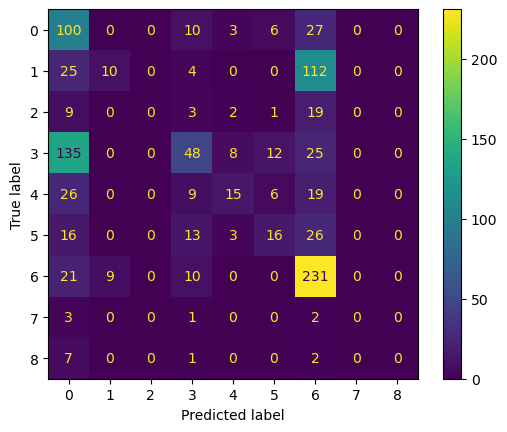

In [38]:
# Criando o Modelo KNN com K - Otimizado
K=80
print(f'Para o K = {K} temos :')

# Treinamento do Modelo KNN Otimizado
modeloKNN = KNeighborsClassifier(n_neighbors = K)
modeloKNN.fit(X_train,y_train)

# Previsão do Modelo KNN Otimizado
predKNN = modeloKNN.predict(X_test)
predKNN_proba = modeloKNN.predict_proba(X_test)

# Métricas do Modelo KNN Otimizado
score1KNN = log_loss(y_test, predKNN_proba, eps=1e-15)
score2KNN = roc_auc_score(y_test, predKNN_proba, multi_class='ovr')

# Matriz de Confusão
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,predKNN))
disp.plot()
plt.show()

Podemos perceber que pela Matriz de Confusão, nosso modelo acerta muito mais as previsões de classes 7 e 1. É um fato que ocorre por não termos a Variável de Saída balanceada, o modelo aprende mais sobre as classes de maior frequência que sobre as classes de menor frequência.

In [39]:
# Salvando os Resultados em um Dataset de Compilação
resultado = {'Modelo KNN': [score1KNN, score2KNN]}
resultado = pd.DataFrame(resultado, index=['Log Loss', 'rAUC'])
resultado

,Modelo KNN
Log Loss,1.739806
rAUC,0.818135


### Modelo 01 - Random Forest Classifier

In [40]:
# Testando o Melhor Valor dos Estimadores
Elist = [3, 10, 20, 30, 50, 80, 100, 200, 300, 500, 800, 1000]

# Lista de Log Loss de E
LogLoss = []
rAUC = []

# Loop de Teste
for E in Elist:
		
	# Treinando o modelo RF com cada valor de E
	modelo = RandomForestClassifier(n_estimators= E, max_depth=9)
	modelo.fit(X_train, y_train)
	# Previsões com o modelo
	pred = modelo.predict_proba(X_test)
	# Avaliando o modelo com a lista de Métricas
	score1 = log_loss(y_test, pred, eps=1e-15)
	score2 = roc_auc_score(y_test, pred, multi_class='ovr')
	print(f'As métricas para E={E} são:\nLog Loss {score1} \nrAUC = {score2}\n------------------------\n')
	LogLoss.append(score1)
	rAUC.append(score2)

As métricas para E=3 são:
Log Loss 1.588718501755847 
rAUC = 0.7680705398708116
------------------------

As métricas para E=10 são:
Log Loss 1.3618397728860574 
rAUC = 0.8628919630568463
------------------------

As métricas para E=20 são:
Log Loss 1.3538509871367217 
rAUC = 0.8729000781936662
------------------------

As métricas para E=30 são:
Log Loss 1.3155455928765336 
rAUC = 0.874587127306645
------------------------

As métricas para E=50 são:
Log Loss 1.2923752135684154 
rAUC = 0.8952951072526827
------------------------

As métricas para E=80 são:
Log Loss 1.3129939160878585 
rAUC = 0.8860501431291453
------------------------

As métricas para E=100 são:
Log Loss 1.3013142923385632 
rAUC = 0.8892347701411101
------------------------

As métricas para E=200 são:
Log Loss 1.3065416928682023 
rAUC = 0.8936404731094836
------------------------

As métricas para E=300 são:
Log Loss 1.30033888946557 
rAUC = 0.8958949986257753
------------------------

As métricas para E=500 são:
Lo

In [41]:
# Visão Gráfica das Métricas
dic = {'E': Elist, 'Log Loss': LogLoss, 'rAUC': rAUC}
data = pd.DataFrame(dic)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Log Loss', 'rAUC'])
fig.add_trace(go.Scatter(x = data['E'], y = data['Log Loss'], mode='lines', showlegend=False), row=1, col=1)
fig.update_yaxes(showticklabels = True)
fig.add_trace(go.Scatter(x = data['E'], y = data['rAUC'], mode='lines', showlegend=False), row=1, col=2)
fig.update_layout(title_text = 'Métricas do Modelo Random Forest Classifier')
fig.show()

Podemos admitir que o melhor valor para o Número de Estimadores E seria 50, visto que temos a menor perda logarítmica e uma boa acurácia em 89.5% com rAUC.

Para o Número de Estimadores E = 50 temos :


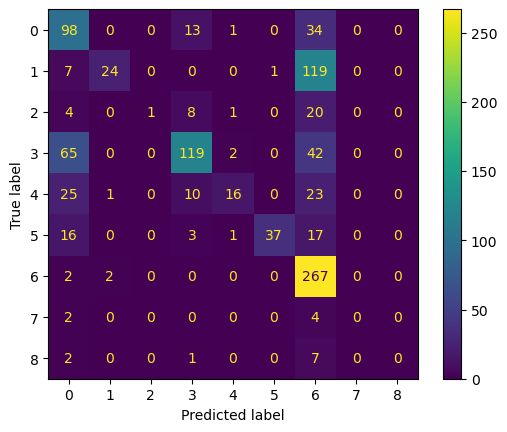

In [42]:
# Criando o Modelo RF com E otimizado
E=50
print(f'Para o Número de Estimadores E = {E} temos :')

# Treinamento do Modelo RF
modeloRF = RandomForestClassifier(n_estimators= E, max_depth= 9)
modeloRF.fit(X_train,y_train)

# Previsão do Modelo RF
predRF = modeloRF.predict(X_test)
predRF_proba = modeloRF.predict_proba(X_test)

# Métricas do Modelo KNN Otimizado
score1RF = log_loss(y_test, predRF_proba, eps=1e-15)
score2RF = roc_auc_score(y_test, predRF_proba, multi_class='ovr')

# Matriz de Confusão
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,predRF))
disp.plot()
plt.show()

Podemos perceber que pela Matriz de Confusão, nosso modelo acerta mais as previsões de classes 1, 4, 6 e 7. Temos claramente uma melhora em relação ao KNN.

In [43]:
# Salvando os Resultados no Dataset de Compilação
resultado['Modelo RF'] = [score1RF, score2RF]
resultado

,Modelo KNN,Modelo RF
Log Loss,1.739806,1.315174
rAUC,0.818135,0.877773


### Modelo 02 - Multinomial Naive Bayes

In [44]:
# Testando o Melhor Valor de Alpha
alpha = np.arange(0.001, 0.01, 0.001)

# Lista de Log Loss de K
LogLoss = []
rAUC = []

# Loop de Teste
for a in alpha:
		
	# Treinando o modelo MNB com cada valor de k
	modelo = MultinomialNB(alpha= a)
	modelo.fit(X_train, y_train)

	# Previsões com o modelo MNB
	pred = modelo.predict_proba(X_test)

	# Avaliando o modelo com a lista de Métricas
	score1 = log_loss(y_test, pred, eps=1e-15)
	score2 = roc_auc_score(y_test, pred, multi_class='ovr')
	print(f'As métricas para aplha = {a} são:\nLog Loss {score1} \nrAUC = {score2}\n------------------------\n')
	LogLoss.append(score1)
	rAUC.append(score2)

As métricas para aplha = 0.001 são:
Log Loss 1.986331007604535 
rAUC = 0.8901304350215504
------------------------

As métricas para aplha = 0.002 são:
Log Loss 1.8695063115405373 
rAUC = 0.8921189515750536
------------------------

As métricas para aplha = 0.003 são:
Log Loss 1.826223437315264 
rAUC = 0.8937109694172661
------------------------

As métricas para aplha = 0.004 são:
Log Loss 1.8107515103646306 
rAUC = 0.8945787406669246
------------------------

As métricas para aplha = 0.005 são:
Log Loss 1.8097576895227006 
rAUC = 0.8948926441100631
------------------------

As métricas para aplha = 0.006 são:
Log Loss 1.817951905715058 
rAUC = 0.8946954990481765
------------------------

As métricas para aplha = 0.007 são:
Log Loss 1.8321227527237165 
rAUC = 0.8940473881777038
------------------------

As métricas para aplha = 0.008 são:
Log Loss 1.8503222674362616 
rAUC = 0.8926344686971448
------------------------

As métricas para aplha = 0.009000000000000001 são:
Log Loss 1.87099

In [45]:
# Visão Gráfica das Métricas
dic = {'alpha': alpha, 'Log Loss': LogLoss, 'rAUC': rAUC}
data = pd.DataFrame(dic)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Log Loss', 'rAUC'])
fig.add_trace(go.Scatter(x = data['alpha'], y = data['Log Loss'], mode='lines', showlegend=False), row=1, col=1)
fig.update_yaxes(showticklabels = True)
fig.add_trace(go.Scatter(x = data['alpha'], y = data['rAUC'], mode='lines', showlegend=False), row=1, col=2)
fig.update_layout(title_text = 'Métricas do Modelo Multinomial Naive Bayes')
fig.show()

Podemos admitir um valor para alpha de 0.005, pois alcançamos um log loss de 1.81 e um rAUC de 89.5%.

Para a Taxa de Aprendizagem alpha = 0.005 temos :


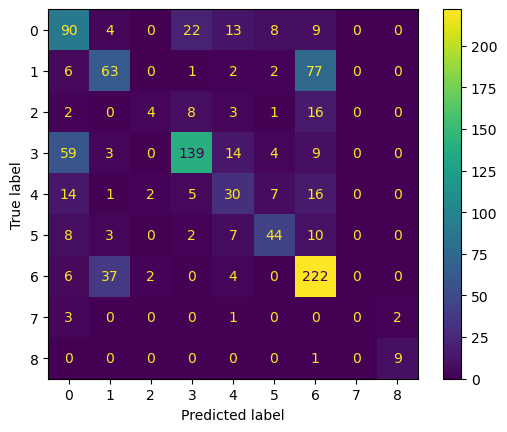

In [50]:
# Criando o Modelo MNB com alpha otimizado
A = 0.005
print(f'Para a Taxa de Aprendizagem alpha = {A} temos :')

# Treinamento do Modelo MNB
modeloMNB = MultinomialNB(alpha = A)
modeloMNB.fit(X_train,y_train)

# Previsão do Modelo MNB
predMNB = modeloMNB.predict(X_test)
predMNB_proba = modeloMNB.predict_proba(X_test)

# Métricas do Modelo MNB Otimizado
score1MNB = log_loss(y_test, predMNB_proba, eps=1e-15)
score2MNB = roc_auc_score(y_test, predMNB_proba, multi_class='ovr')
# Matriz de Confusão
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,predMNB))
disp.plot()
plt.show()

Evoluimos em nossas previsões, alcançando mais acertos e menos erros para todas as Classes!

In [51]:
# Salvando os Resultados no Dataset de Compilação
resultado['Modelo MNB'] = [score1MNB, score2MNB]
resultado

,Modelo KNN,Modelo RF,Modelo MNB
Log Loss,1.739806,1.315174,1.809758
rAUC,0.818135,0.877773,0.894893


### Modelo 03 - Stochastic Gradient Descent Classifier

In [48]:
# Testando o Melhor Valor de Alpha
alpha = np.arange(1e-6, 1e-4, 1e-5)

# Lista de Log Loss de K
LogLoss = []
rAUC = []

# Loop de Teste
for a in alpha:
		
	# Treinando o modelo MNB com cada valor de k
	modelo = SGDClassifier(loss = 'log' ,alpha = a ,penalty = 'l2' ,shuffle = True , class_weight = 'balanced', random_state = 0)
	modelo.fit(X_train, y_train)
	
	# Previsões com o modelo MNB
	pred = modelo.predict_proba(X_test)

	# Avaliando o modelo com a lista de Métricas
	score1 = log_loss(y_test, pred, eps=1e-15)
	score2 = roc_auc_score(y_test, pred, multi_class='ovr')
	print(f'As métricas para aplha = {a} são:\nLog Loss {score1} \nrAUC = {score2}\n------------------------\n')
	LogLoss.append(score1)
	rAUC.append(score2)

As métricas para aplha = 1e-06 são:
Log Loss 2.465576114086081 
rAUC = 0.8718152520486088
------------------------

As métricas para aplha = 1.1000000000000001e-05 são:
Log Loss 1.103728365277631 
rAUC = 0.894958588837818
------------------------

As métricas para aplha = 2.1000000000000002e-05 são:
Log Loss 1.063389495247917 
rAUC = 0.8956276703115074
------------------------

As métricas para aplha = 3.1e-05 são:
Log Loss 1.0609805418305134 
rAUC = 0.8963684957964951
------------------------

As métricas para aplha = 4.1e-05 são:
Log Loss 1.0621328273267892 
rAUC = 0.8988846138414817
------------------------

As métricas para aplha = 5.1e-05 são:
Log Loss 1.0736573068759645 
rAUC = 0.8993695541944818
------------------------

As métricas para aplha = 6.1000000000000005e-05 são:
Log Loss 1.0746356388066716 
rAUC = 0.9003517855495805
------------------------

As métricas para aplha = 7.1e-05 são:
Log Loss 1.099807015677233 
rAUC = 0.9012197126788707
------------------------

As métrica

In [49]:
# Visão Gráfica das Métricas
dic = {'alpha': alpha, 'Log Loss': LogLoss, 'rAUC': rAUC}
data = pd.DataFrame(dic)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Log Loss', 'rAUC'])
fig.add_trace(go.Scatter(x = data['alpha'], y = data['Log Loss'], mode='lines', showlegend=False), row=1, col=1)
fig.update_yaxes(showticklabels = True)
fig.add_trace(go.Scatter(x = data['alpha'], y = data['rAUC'], mode='lines', showlegend=False), row=1, col=2)
fig.update_layout(title_text = 'Métricas do Modelo SGDC')
fig.show()

Podemos definir que a melhor taxa de aprednizado alpha é 2.1e-5, nos dando um Log Loss próximo de 1.06 e um rAUC de 89.5%.

Para a Taxa de Aprendizagem alpha 2.1e-05 temos :


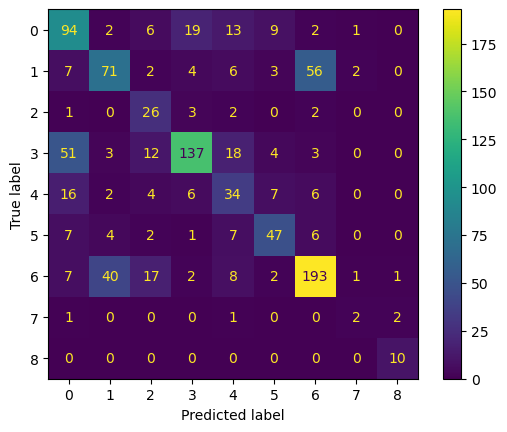

In [52]:
# Criando o Modelo SGDC com alpha otimizado
A = 2.1e-5
print(f'Para a Taxa de Aprendizagem alpha {A} temos :')

# Treinamento do Modelo SGDC
modeloSGDC = SGDClassifier(alpha = A, loss = 'log' ,penalty = 'l2' ,shuffle = True , class_weight = 'balanced', random_state = 0)
modeloSGDC.fit(X_train,y_train)

# Previsão do Modelo SGDC
predSGDC = modeloSGDC.predict(X_test)
predSGDC_proba = modeloSGDC.predict_proba(X_test)

# Métricas do Modelo SGDC Otimizado
score1SGDC = log_loss(y_test, predSGDC_proba, eps=1e-15)
score2SGDC = roc_auc_score(y_test, predSGDC_proba, multi_class='ovr')
# Matriz de Confusão
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,predSGDC))
disp.plot()
plt.show()

Pela Matrix de Confusão percebemos que nosso modelo acertou muito mais que errou em todas as classes.

In [53]:
# Salvando os Resultados no Dataset de Compilação
resultado['Modelo SGDC'] = [score1SGDC, score2SGDC]
resultado

,Modelo KNN,Modelo RF,Modelo MNB,Modelo SGDC
Log Loss,1.739806,1.315174,1.809758,1.063389
rAUC,0.818135,0.877773,0.894893,0.895628


Finalizamos nossa Modelagem Preditiva escolhendo o Modelo SGDC como nosso melhor modelo. Vamos agora realizar a Classificação de Novos dados e Entregar ao nosso Cliente Final.

## Deploy do Modelo com Dados Novos

In [54]:
# Verificando se Temos dados Ausentes
df = dft.copy()
df.isna().sum()

ID           0
Text         1
Gene         0
Variation    0
dtype: int64

In [55]:
# Eliminando dados Ausentes
df = df.dropna()
df.isna().sum()

ID           0
Text         0
Gene         0
Variation    0
dtype: int64

In [56]:
# Aplicando a Função text_process no Dataset
df['Text'] = df['Text'].apply(text_process)
print(df.info())
print(df.isnull().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5667 entries, 0 to 5667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5667 non-null   int64 
 1   Text       5667 non-null   object
 2   Gene       5667 non-null   object
 3   Variation  5667 non-null   object
dtypes: int64(1), object(3)
memory usage: 221.4+ KB
None
ID           0
Text         0
Gene         0
Variation    0
dtype: int64


,ID,Text,Gene,Variation
0,0,2 this mutation resulted in a myeloproliferati...,ACSL4,R570S
1,1,abstract the large tumor suppressor 1 lats1 is...,NAGLU,P521L
2,2,vascular endothelial growth factor receptor ve...,PAH,L333F
3,3,inflammatory myofibroblastic tumor imt is a ne...,ING1,A148D
4,4,abstract retinoblastoma is a pediatric retinal...,TMEM216,G77A


In [57]:
# Aplicando Vetorização nos dados com TF-IDF na Variável Text
X = vetorizador.transform(df.Text)
X

<5667x153173 sparse matrix of type '<class 'numpy.float64'>'
	with 10485176 stored elements in Compressed Sparse Row format>

In [58]:
# Classificando os dados com o Modelo SGDC
Classe = modeloSGDC.predict(X)
Classe = pd.Series(Classe)

In [59]:
# Organizando a Planilha de Entrega para o Cliente 
DadosClassificados = dft.drop(columns=['Text'])
DadosClassificados['Classe do Cancer'] = Classe
DadosClassificados.head(10)

,ID,Gene,Variation,Classe do Cancer
0,0,ACSL4,R570S,7.0
1,1,NAGLU,P521L,4.0
2,2,PAH,L333F,2.0
3,3,ING1,A148D,7.0
4,4,TMEM216,G77A,4.0
5,5,CD40LG,A123E,4.0
6,6,KLF11,T220M,7.0
7,7,SGCB,T151R,4.0
8,8,CLCF1,R197L,1.0
9,9,SDHAF1,R55P,7.0


Projeto Entregue, Cliente Feliz! Bora pro Próximo!!